In [80]:
import os
import matplotlib.pyplot as plt
import skimage
import numpy as np
from scipy import ndimage as ndi
from skimage import io

In [ ]:
teste_01 = io.imread('photos/bios/GUU-Draco-Amo9-29Mai70-515-29,1-2-0,5-DIR.jpg')
teste_02 = io.imread('photos/bios/GUU-Mar Roxo-Amo4-27Fev08-202-23,4-2,5-0,5-ESQ.jpg')
teste_03 = io.imread('photos/AM3 CL_20112018/CL19_20112018.jpg')
teste_04 = io.imread('photos/NOVAS FOTOS/0004.tif', plugin='pil')

# Função: Prototipo 1:

In [413]:
def processador(imagem, plot:bool=True):
    colapsado = skimage.color.rgb2gray(imagem)

    # detecta a borda e cria uma mascara
    markers = np.zeros_like(colapsado)
    markers[colapsado < 0.1] = 1 # como determinar este valor?
    markers[colapsado> 0.8] = 2 # como determinar este valor?

    edge = skimage.filters.sobel(colapsado)
    segmentation_edge = skimage.segmentation.watershed(edge, markers)

    # limpeza do segmentation edge
    mascara = segmentation_edge-1

    # identifica o objecto maior
    otolito = skimage.filters.apply_hysteresis_threshold(colapsado*segmentation_edge, high = 0.6, low = 0.4) # validar valores
    labeled = ndi.label(otolito)[0]
    otolito = skimage.color.label2rgb(labeled, mascara)

    # identifica o centroide
    largest_nonzero_label = np.argmax(np.bincount(labeled[labeled > 0]))
    binary = labeled == largest_nonzero_label
    skeleton = skimage.morphology.skeletonize(binary)
    g, nodes = skimage.graph.pixel_graph(skeleton, connectivity=2)
    px, distances = skimage.graph.central_pixel(
    g, nodes=nodes, shape=skeleton.shape, partition_size=100)

    centroid = skimage.measure.centroid(labeled > 0)

    # identifica a borda pixel a pixel?
    borda = skimage.measure.find_contours(binary) # em vez de segmentation edge?

    # calcula extremo do rostro
    origin_x, origin_y = px[1], px[0]
    res = []
    for array in borda:
        for line in array:
            res.append(line.tolist())

    distancia = []
    for item in res:
        distancia.append(np.sqrt((origin_y-item[1])**2 + np.sqrt(origin_x-item[0])**2))
    max_index = distancia.index(max(distancia))
    extremo = res[max_index]

    # linha de perfil a partir do centroide
    profile = skimage.measure.profile_line(colapsado, src = (origin_x, origin_y), dst = (extremo[1],extremo[0]))

    # plots
    if plot:
        f, ax = plt.subplots(2,3, figsize = (40,20))
        # imagem original em grayscale
        ax[0,0].imshow(colapsado, cmap = plt.cm.gray)
        # imagem original depois de retirar o fundo por watershed
        ax[0,1].imshow(colapsado * mascara, cmap = plt.cm.gray)
        # histograma da imagem original
        histogram, bin_edges = np.histogram(colapsado, bins=100, range=(0, 1))
        ax[0,2].plot(bin_edges[0:-1], histogram)
        # regiao do otolito determinada por hysteresis
        ax[1,0].imshow(otolito, cmap = plt.cm.gray)
        # centroide, borda e linha de perfil do otolito

        origin = [origin_x, extremo[1]]
        dest = [origin_y,extremo[0]]

        ax[1,1].imshow(skimage.color.label2rgb(skeleton, colapsado*mascara))
        ax[1,1].plot(origin, dest, linewidth = 5, color = 'r')
        ax[1,1].scatter(px[1], px[0], label='graph center')
        ax[1,1].scatter(centroid[1], centroid[0], label='centroid')
        ax[1,1].legend()
        ax[1,1].set_axis_off()
        ax[1,1].set_title('graph center vs centroid')
        for contour in borda:
            ax[1,1].plot(contour[:, 1], contour[:, 0], linewidth=4, color = 'r')

        # perfil desenhado do otolito
        ax[1,2].plot(profile)

        #ax[2,0].imshow(imagem)



    #return borda

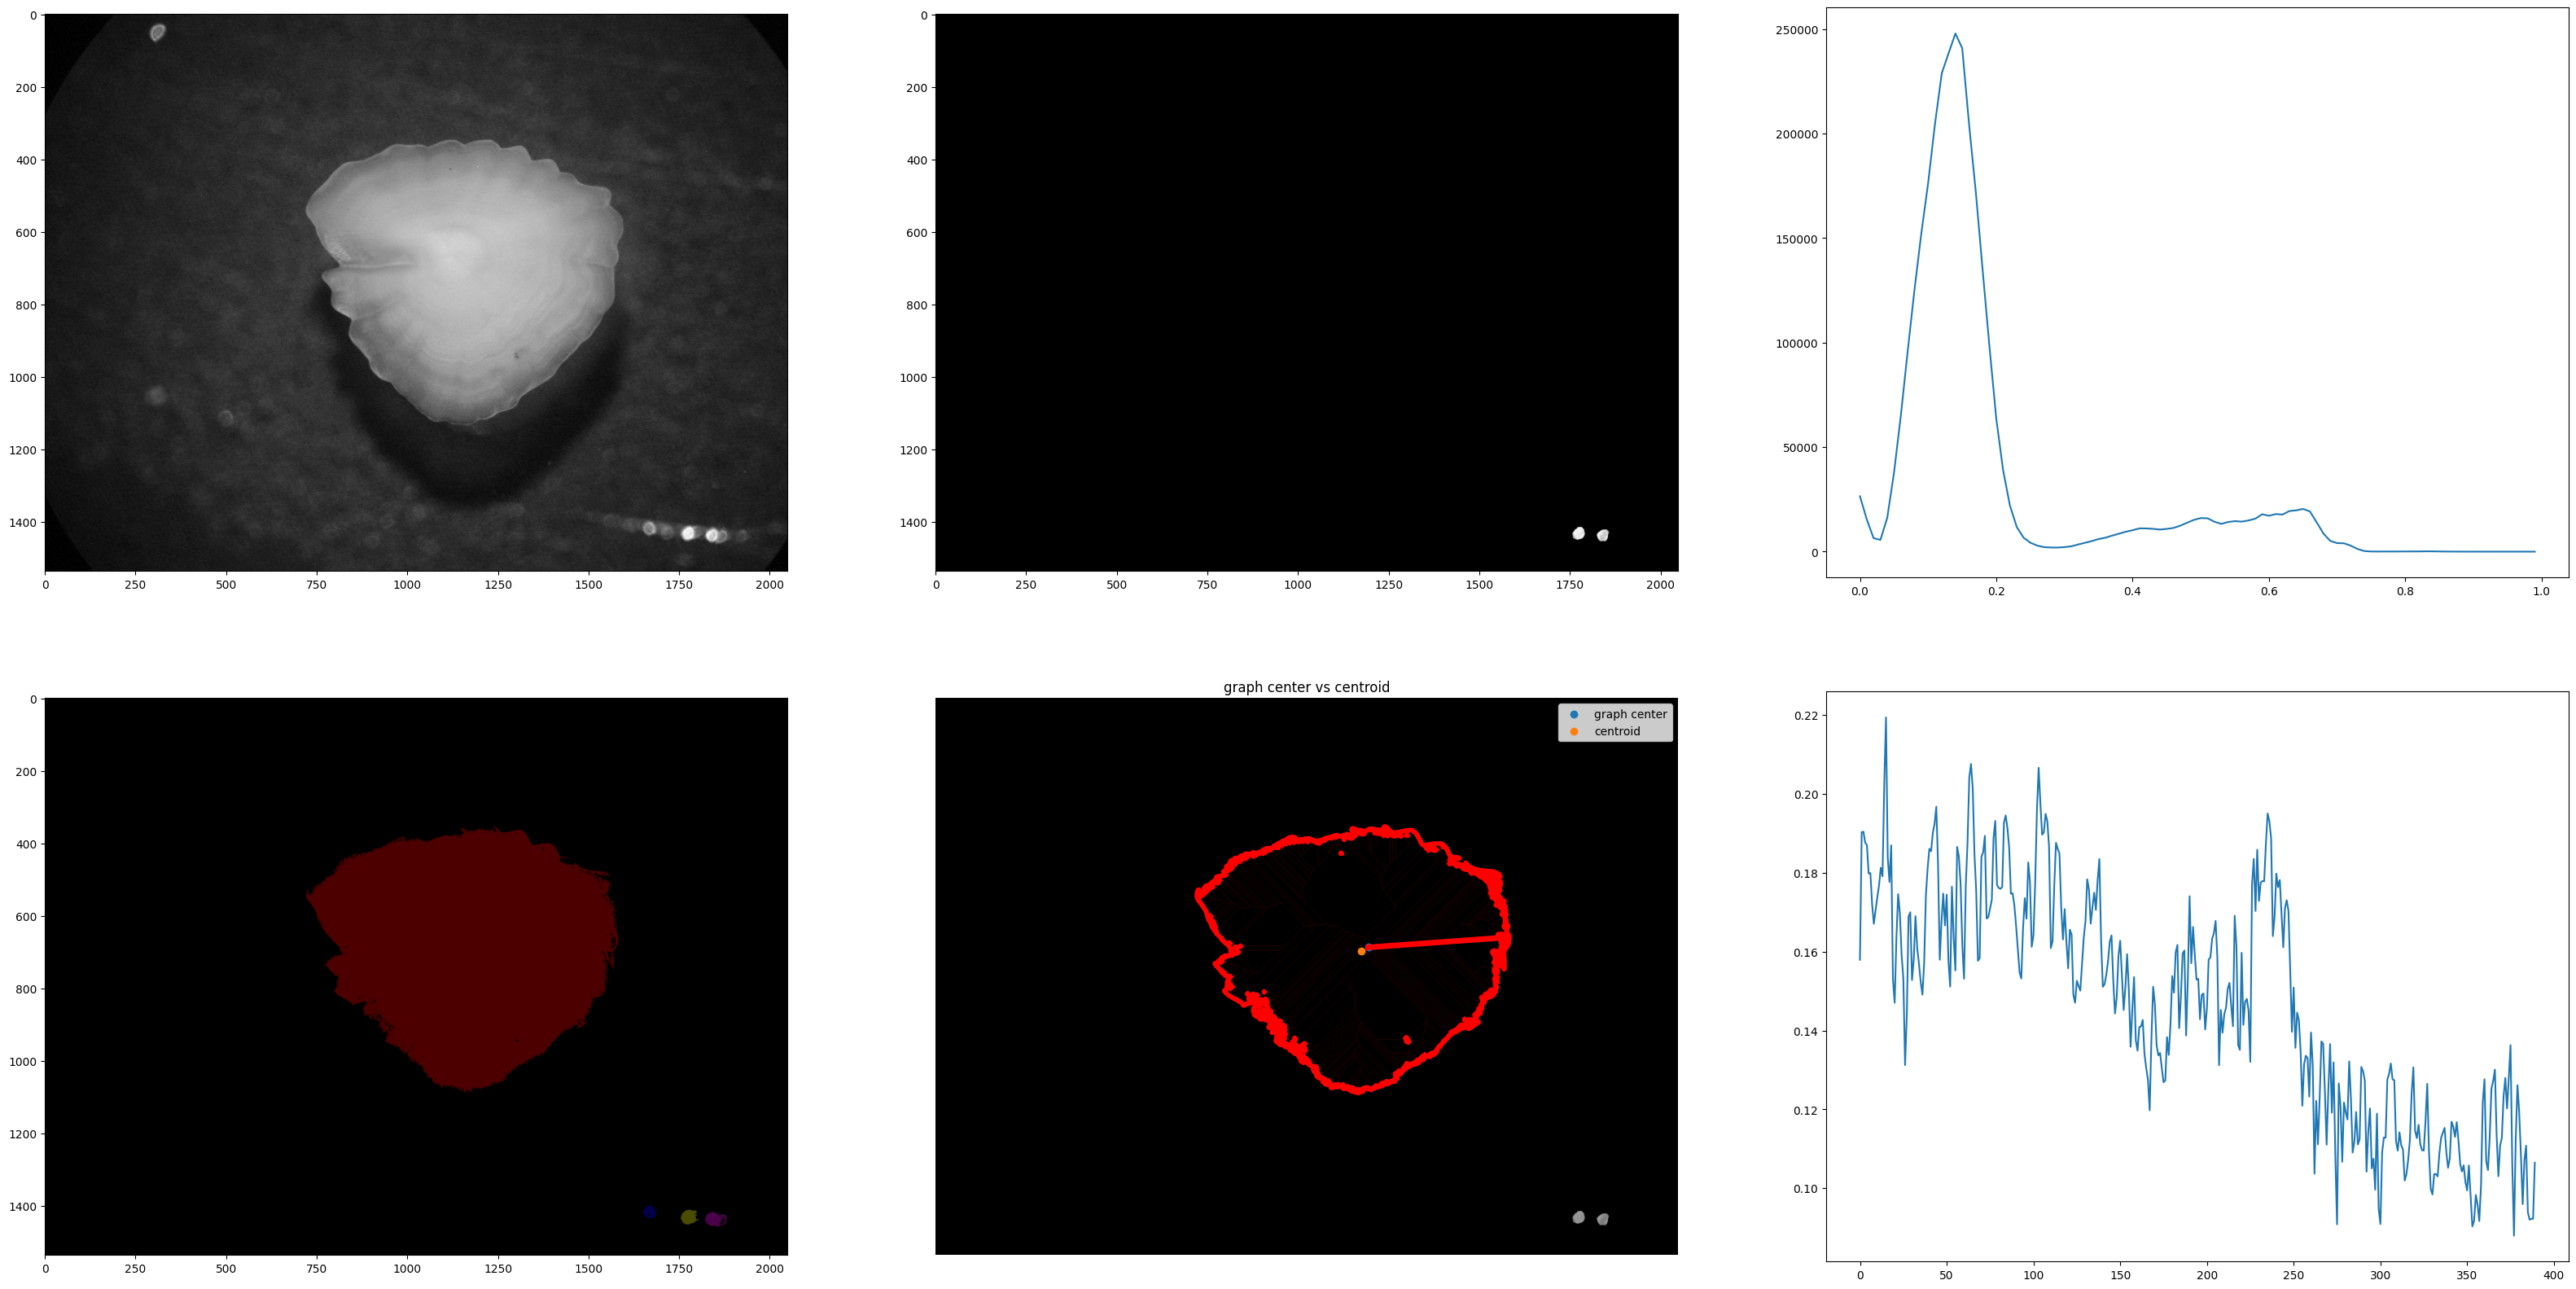

In [415]:
processador(teste_04, True)

https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html